In [165]:
#IMPORT THE PACKAGES
import os, keras, cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import datetime
from keras import layers, losses, callbacks, activations, regularizers, metrics, applications, optimizers

In [ ]:
#LOAD THE DATA
data = os.path.join(os.getcwd(),'dataset')
BATCH_SIZE = 10
IMG_SIZE = (160, 160)
train_d, val_d = keras.utils.image_dataset_from_directory(data,
                                                          shuffle=True,
                                                          batch_size=BATCH_SIZE,
                                                          image_size=IMG_SIZE,
                                                          validation_split=0.3,
                                                          subset='both',
                                                          seed=42)

Found 3822 files belonging to 8 classes.
Using 2676 files for training.
Using 1146 files for validation.


['Blazer', 'Denim_Jacket', 'Hoodie', 'Jeans', 'Shorts', 'T shirt', 'button_shirts', 'long_pants']


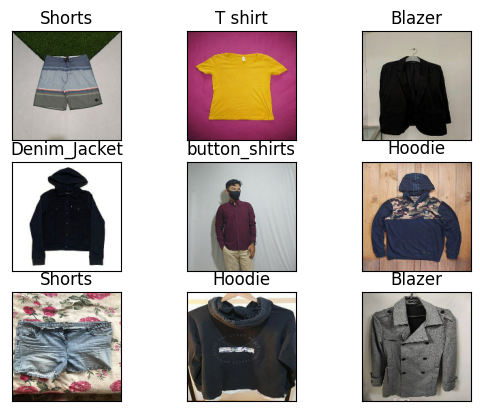

In [167]:
#plot the images
class_names = train_d.class_names
print(class_names)
batch_1 = train_d.take(1)
for feature, label in batch_1:
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(feature[i].numpy().astype('uint8'))
        plt.title(class_names[label[i]])
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
    plt.show()

In [168]:
#Convert the val dataset back to PrefetchDataset
val_d = val_d.prefetch(buffer_size=tf.data.AUTOTUNE)

In [169]:
#Create a sequential model for augmentation
data_aug = keras.Sequential()
data_aug.add(layers.RandomFlip())
data_aug.add(layers.RandomRotation(factor=0.2))

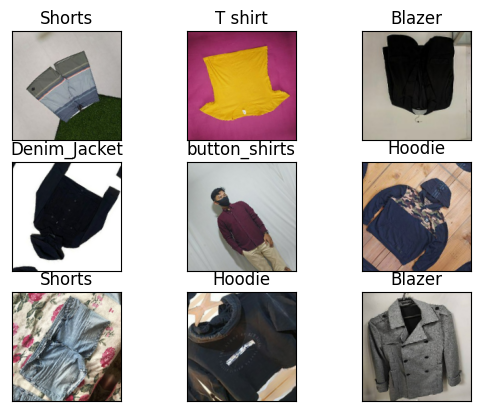

In [170]:
# Test feature augmentation
feature_augmented = data_aug(feature)
for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(feature_augmented[i].numpy().astype('uint8'))
        plt.title(class_names[label[i]])
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
plt.show()

In [171]:
# Create the preprocessing layer based on the pretrained model that we will use
preprocess_input = applications.mobilenet_v2.preprocess_input

In [172]:
# apply transfer learning using pretrained model
IMG_SHAPE = IMG_SIZE + (3,)
base_model = applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet',alpha=0.5)
# freeze the feature extractor to make sure we only train the classifier
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_0.50_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_28      │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        432 │ input_layer_28[0… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │         64 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        144 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80, 8) │        128 │ expanded_conv_de… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80, 8) │         32 │ expanded_conv_pr… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │        384 │ expanded_conv_pr… │
│ (Conv2D)            │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        192 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        432 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        192 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │        768 │ block_1_depthwis

 Total params: 706,224 (2.69 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 706,224 (2.69 MB)

In [173]:
# construct classifier
global_avg = layers.GlobalAveragePooling2D()
output_layer = layers.Dense(len(class_names), activation='softmax')

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_29 (InputLayer)     │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_9 (Sequential)       │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_9 (TrueDivide)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_9 (Subtract)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_0.50_160            │ (None, 5, 5, 1280)     │       706,224 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_9      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 8)              │        10,248 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 716,472 (2.73 MB)

 Trainable params: 10,248 (40.03 KB)

 Non-trainable params: 706,224 (2.69 MB)

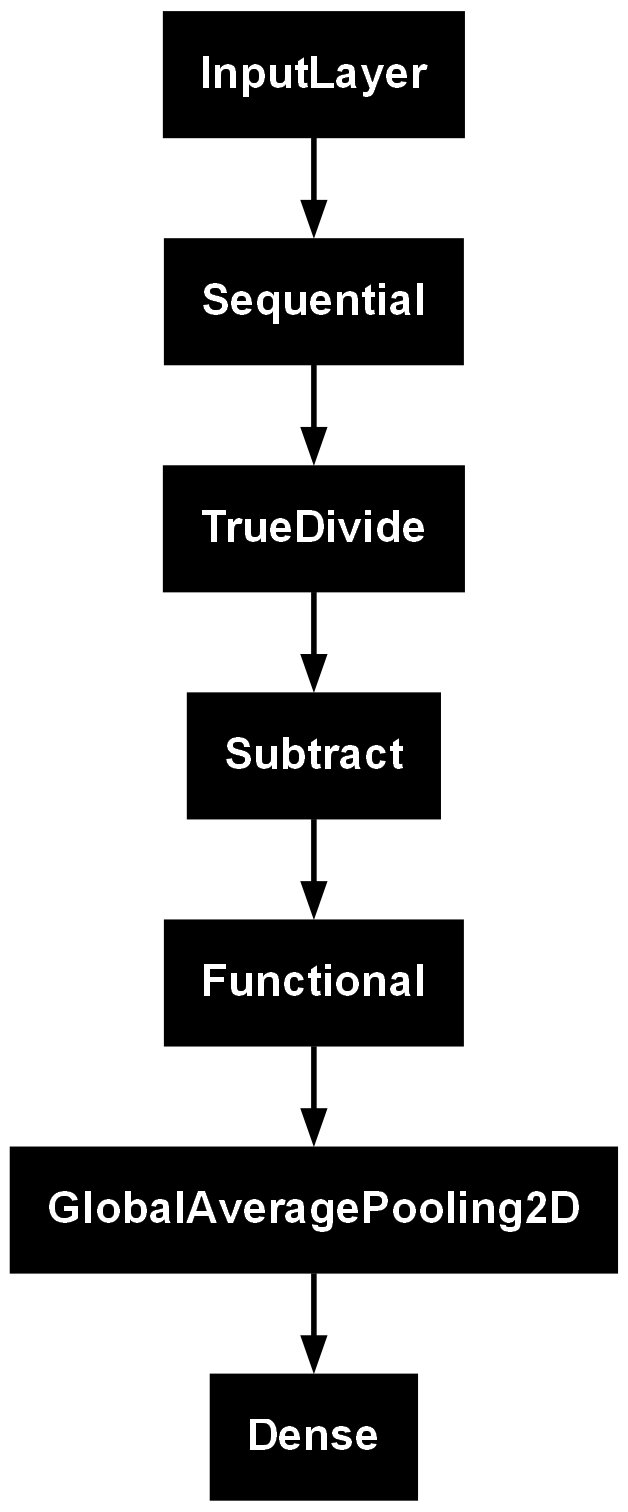

In [174]:
# use functional api to connect all layers
inputs = keras.Input(shape=IMG_SHAPE)
# augmentation layers
x = data_aug(inputs)
# preprocessing layer
x = preprocess_input(x)
# feature extractor
x = base_model(x)
# classifier
x = global_avg(x)
outputs = output_layer(x)
# create model
model = keras.Model(inputs = inputs, outputs= outputs)
model.summary()
keras.utils.plot_model(model=model)

In [175]:
# compile model
optimizer = optimizers.Adam(learning_rate=0.001)
loss = losses.SparseCategoricalCrossentropy()
model.compile(optimizer= optimizer, loss=loss, metrics=['accuracy'])

In [176]:
# train model
epochs = 15
history_first = model.fit(train_d, validation_data=val_d, epochs=epochs)

Epoch 1/15
268/268 ━━━━━━━━━━━━━━━━━━━━ 17s 51ms/step - accuracy: 0.4595 - loss: 1.5746 - val_accuracy: 0.7496 - val_loss: 0.7715
Epoch 2/15
268/268 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - accuracy: 0.7101 - loss: 0.8260 - val_accuracy: 0.7897 - val_loss: 0.6561
Epoch 3/15
268/268 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - accuracy: 0.7527 - loss: 0.7112 - val_accuracy: 0.7914 - val_loss: 0.6277
Epoch 4/15
268/268 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.7810 - loss: 0.6394 - val_accuracy: 0.7914 - val_loss: 0.6158
Epoch 5/15
268/268 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - accuracy: 0.7903 - loss: 0.6080 - val_accuracy: 0.7784 - val_loss: 0.6502
Epoch 6/15
268/268 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.7974 - loss: 0.5841 - val_accuracy: 0.7880 - val_loss: 0.6185
Epoch 7/15
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.8156 - loss: 0.5234 - val_accuracy: 0.7976 - val_loss: 0.6251
Epoch 8/15
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8221 - loss: 0.5130 - 

In [177]:
# Evaluate the model after the first stage training
model.evaluate(val_d)

115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.8260 - loss: 0.5525


[0.5986274480819702, 0.8089005351066589]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 900ms/step
['long_pants', 'button_shirts', 'T shirt', 'Blazer', 'Shorts', 'button_shirts', 'button_shirts', 'button_shirts', 'T shirt', 'Jeans']


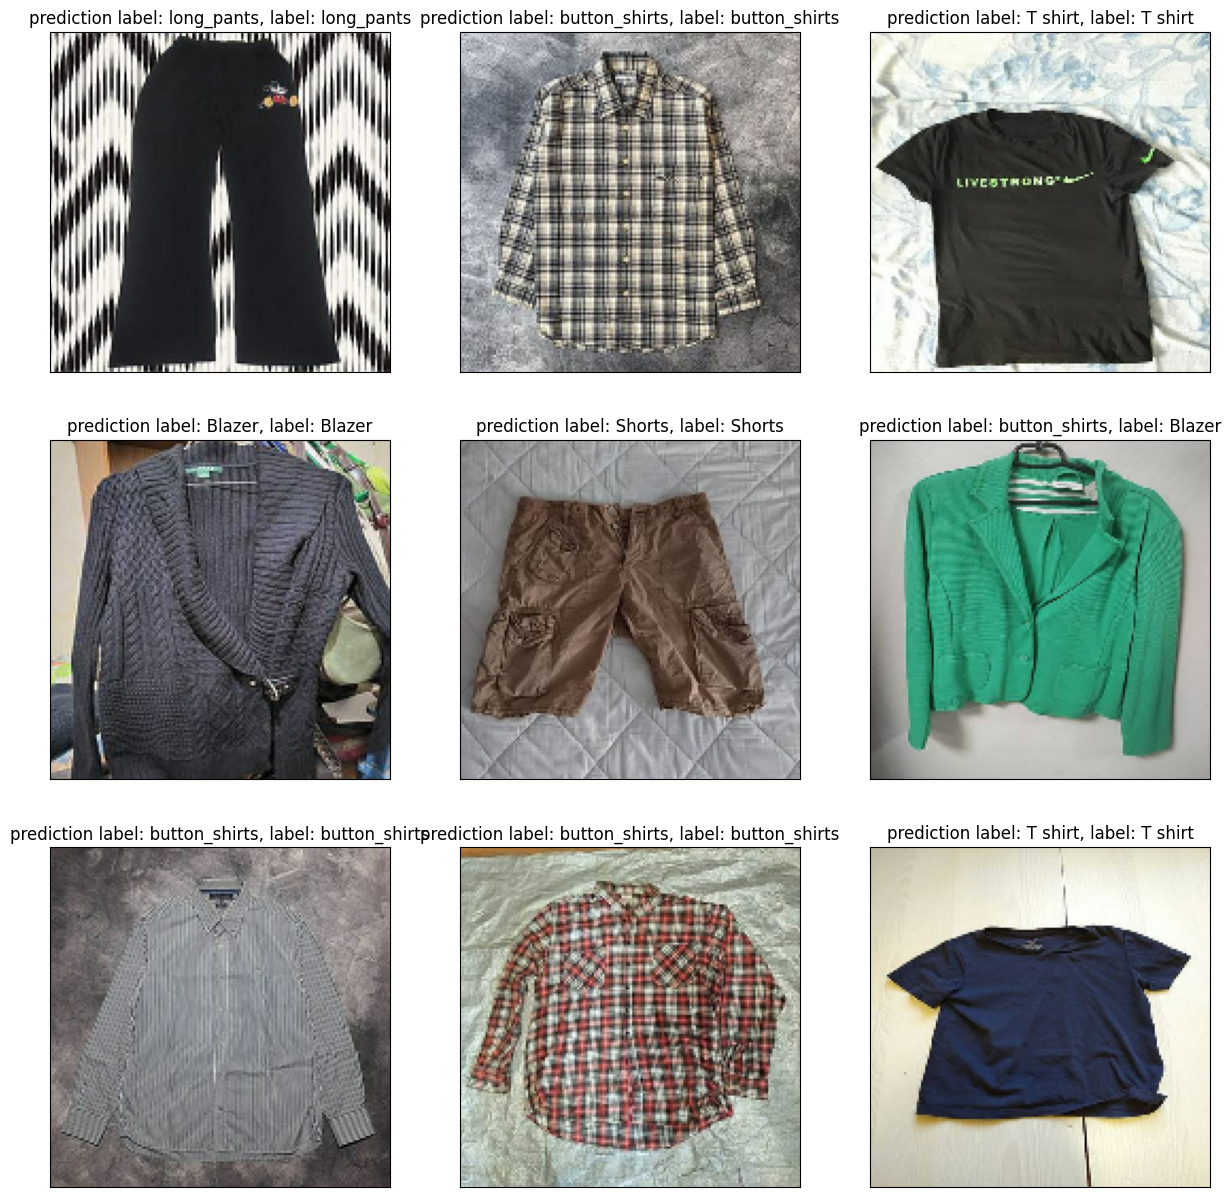

In [178]:
#make a prediction
for image_batch, label_batch in val_d.take(1):
    y_pred = np.argmax(model.predict(image_batch),axis=1)
    predicted_class = [class_names[x] for x in y_pred]
print(predicted_class)

plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(f'prediction label: {predicted_class[i]}, label: {class_names[label_batch[i]]}')
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
plt.show()

In [179]:
# 2nd stage transfer learning
# unfreeze model
base_model.trainable = True
# free earlier model of the base model
finetune_at = 100
for layer in base_model.layers[:finetune_at]:
    layer.trainable = False
base_model.summary()

Model: "mobilenetv2_0.50_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_28      │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        432 │ input_layer_28[0… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │         64 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        144 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80, 8) │        128 │ expanded_conv_de… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80, 8) │         32 │ expanded_conv_pr… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │        384 │ expanded_conv_pr… │
│ (Conv2D)            │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        192 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        432 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        192 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │        768 │ block_1_depthwis

 Total params: 706,224 (2.69 MB)

 Trainable params: 584,864 (2.23 MB)

 Non-trainable params: 121,360 (474.06 KB)

In [180]:

second_epochs = 20
total_epochs = epochs + second_epochs
starting_epoch = history_first.epoch[-1] + 1
history_second = model.fit(train_d, validation_data=val_d, epochs=total_epochs, batch_size=BATCH_SIZE, initial_epoch=starting_epoch)


Epoch 16/35
268/268 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - accuracy: 0.8659 - loss: 0.3734 - val_accuracy: 0.7941 - val_loss: 0.6386
Epoch 17/35
268/268 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - accuracy: 0.8701 - loss: 0.3745 - val_accuracy: 0.7871 - val_loss: 0.6471
Epoch 18/35
268/268 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - accuracy: 0.8581 - loss: 0.3869 - val_accuracy: 0.8072 - val_loss: 0.5997
Epoch 19/35
268/268 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - accuracy: 0.8614 - loss: 0.3713 - val_accuracy: 0.7810 - val_loss: 0.6760
Epoch 20/35
268/268 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - accuracy: 0.8573 - loss: 0.3813 - val_accuracy: 0.7984 - val_loss: 0.6197
Epoch 21/35
268/268 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - accuracy: 0.8784 - loss: 0.3555 - val_accuracy: 0.7880 - val_loss: 0.6326
Epoch 22/35
268/268 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - accuracy: 0.8832 - loss: 0.3227 - val_accuracy: 0.8002 - val_loss: 0.6365
Epoch 23/35
268/268 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - accuracy: 0.8700 - loss: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
['long_pants', 'button_shirts', 'Hoodie', 'Blazer', 'Shorts', 'button_shirts', 'button_shirts', 'button_shirts', 'T shirt', 'Jeans']


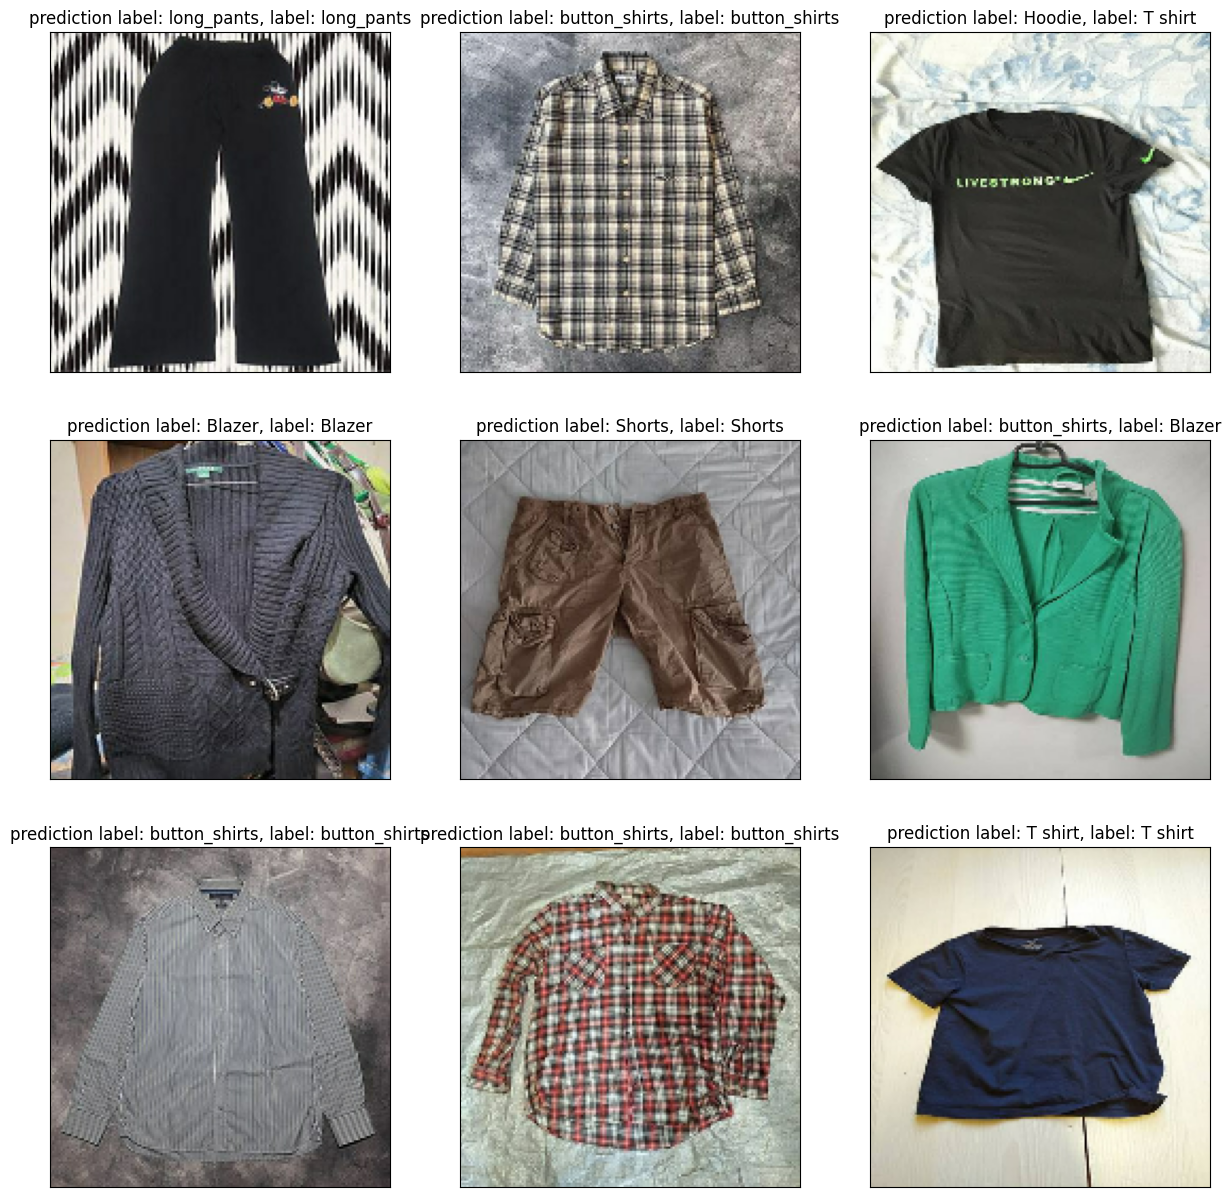

In [181]:
#make a prediction
for image_batch, label_batch in val_d.take(1):
    y_pred = np.argmax(model.predict(image_batch),axis=1)
    predicted_class = [class_names[x] for x in y_pred]
print(predicted_class)

plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(f'prediction label: {predicted_class[i]}, label: {class_names[label_batch[i]]}')
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
plt.show()

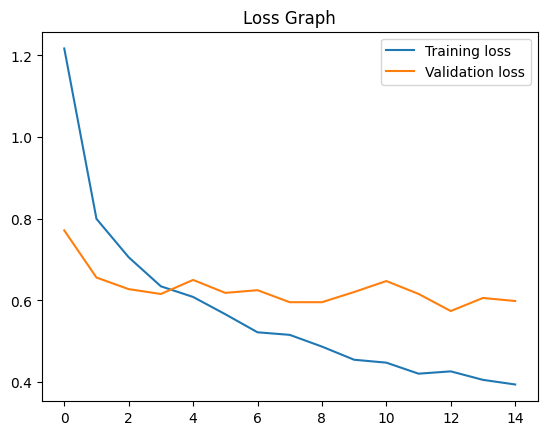

In [182]:
plt.plot(history_first.history['loss'])
plt.plot(history_first.history['val_loss'])
plt.title('Loss Graph')
plt.legend(['Training loss','Validation loss'])
plt.show()

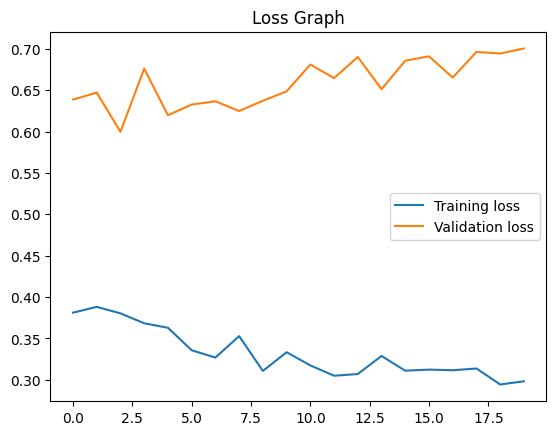

In [183]:
plt.plot(history_second.history['loss'])
plt.plot(history_second.history['val_loss'])
plt.title('Loss Graph')
plt.legend(['Training loss','Validation loss'])
plt.show()

In [184]:
image = cv2.imread(r"C:\Users\suhaimi\Documents\Capstone custom\images\General shirt\th (1).jpg")
print(image.shape)
print(IMG_SHAPE[:2])
image = cv2.resize(image, (IMG_SHAPE[:2]))
image = np.expand_dims(image, axis=0)
predict = np.argmax(model.predict(image))
predicted_class = class_names[predict]
print(predicted_class)

(184, 184, 3)
(160, 160)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 848ms/step
button_shirts


In [186]:
print(class_names)

['Blazer', 'Denim_Jacket', 'Hoodie', 'Jeans', 'Shorts', 'T shirt', 'button_shirts', 'long_pants']


In [185]:
#save model
model_filepath = os.path.join(os.getcwd(),'models','model_class.keras')
model.save(model_filepath, overwrite=True, zipped=None)
